In [2]:
#As always, we import everything
import pandas as pd
import os
import re
import hdf5_getters as getters
import requests
from bs4 import BeautifulSoup
import numpy as np
from collections import OrderedDict
from tqdm import tqdm
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords as stop_words
from textblob import Word
import pycountry
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from gensim import corpora, models
import matplotlib.pyplot as plt
import json
import pickle
import lyricfetcher
import csv
import urllib
from urllib.request import urlopen, HTTPError
import langdetect

import warnings
warnings.filterwarnings('ignore')

data_dir = './' + 'data'

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Table of content

1. [Introduction](#intro)

# 1. <a name="intro"></a>Introduction

Ever since the beginning of the 20th century, a number of political and social movements have arisen with the goal of empowering women and pushing for social equality of sexes. For this ADA project, we are interested in seeing how feminism, and women in general, are represented in the recent music industry.

Music has changed a lot during the recent years. In this project, we propose simple models to identify feminist or sexist songs and see how they distribute throughout the years and genres of music. How would you think things are changing in the music industry?

# 2. Data Collection and Descriptive Analysis

## 2.1 Collecting and combining song metadata

We based our project on the <a href="https://labrosa.ee.columbia.edu/millionsong/">Million Song Dataset</a>. The Million Song Dataset is a freely-available collection of audio features and metadata for a million contemporary popular music tracks.  The Million Song Dataset is also a cluster of complementary datasets contributed by the community, such as the <a href="https://labrosa.ee.columbia.edu/millionsong/musixmatch">musicXmatch </a>, the official lyrics collection of the Million Song Dataset or genre annotation datasets.

We first created a dataframe using the Tagtraum genre annotation dataset (genre_dataset). This dataset contains genre information for 191401 songs.
Then, we create an other dataframe, "year_dataset", using the part of the MSD that has information about the year each track was released. In addition to year, it also contains track_id, the name of the artist, and title of the track. This "year_dataset" contains 515576 data points.
We combine the "genre_dataset" dataframe with the "year_dataset" dataframe: since we wanted to analyze the progression of feminism through lyrics over time, and we were also interested in how women were portrayed in different genres of music, we decided to take the intersection of these datasets (inner join on track ID), and the resulting data frame contains 152793 data points. This final dataset will be the one we will conduct our study on.

The resulting dataframe contains information about Track ID, Year, Artist Name, Title of the song and Genre of the song.
The years span from 1922 to 2010 and the genres come as a single label for each song, with few standards categories only. We decided not to use annotations like "pop-rock", "fusion jazz" and other combinations of genres in order to simplify the analysis of the data.

In [3]:
# Resulting Dataset
year_artist_name_title_genre = pd.read_csv(os.path.join(data_dir + "/year_artist_name_title_genre.csv")).set_index('track_id')
year_artist_name_title_genre.head()

,year,artist_name,title,genre
track_id,,,,
TRSGHLU128F421DF83,1922,alberta hunter,don't pan me,Blues
TRRAHXQ128F42511FF,1922,barrington levy,looking my love,Reggae
TRFAFTK12903CC77B8,1922,barrington levy,warm and sunny day,Reggae
TRTRKSF12903CFEDD7,1924,vernon dalhart,wreck of the old 97,Country
TRQYSYF128F935F350,1925,bessie smith,careless love blues,Blues


In [4]:
year_artist_name_title_genre.isna().sum()

year           0
artist_name    0
title          0
genre          0
dtype: int64

We see that our data is clean, without Nan values or missing values.

## 2.2  Descriptive analysis of the metadata

First, we are interested in seeing how many songs are represented per genre.

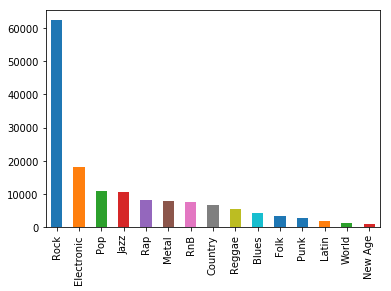

In [5]:
value_count_by_genre = year_artist_name_title_genre['genre'].value_counts().plot(kind = 'bar')

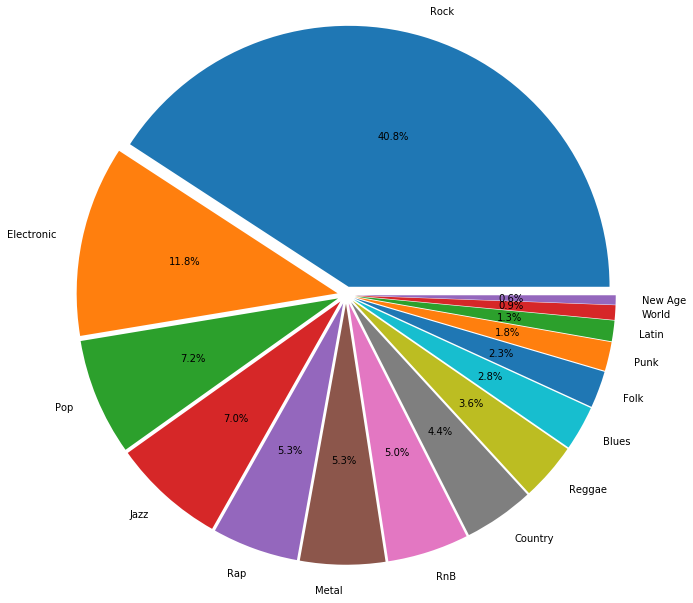

In [6]:
plot = plt.pie(year_artist_name_title_genre['genre'].value_counts(), labels = year_artist_name_title_genre['genre'].value_counts().index.tolist(), autopct='%1.1f%%', explode= [0.1]*len(year_artist_name_title_genre['genre'].value_counts()), radius = 3)

We see an abundance of Rock music in this dataset as close to half of the songs (40.8 %) present are labelled as Rock music. We wonder why that is. Is Rock Music more likely to get labelled?

Ok, stop joking. We suspect that this is due to the fast growth of Rock music during the 1990s and 2000s. We will explore the relationship between year and genre of music further to confirm our hypothesis. 

Let us first have a look at how our data is distributed throughout the decades. Upon quick analysis we realize that the dataset contains music up to the year 2010. We consider the few songs released in 2010 as part of the 2000s, as it is more convenient for simple result visualisation.

In [7]:
# create decade column
year_artist_name_title_genre['decade'] = (year_artist_name_title_genre['year'] // 10) * 10

# include year 2010 in the 2000s decade
year_artist_name_title_genre['decade'] = np.where(year_artist_name_title_genre.year.isin(['2010']),'2000', 
                                                  year_artist_name_title_genre['decade'])

In [8]:
round(100*year_artist_name_title_genre['decade'].value_counts().cumsum() / year_artist_name_title_genre['decade'].value_counts().sum(),3)

2000     58.706
1990     82.721
1980     91.361
1970     96.819
1960     99.162
1950     99.780
1940     99.870
1930     99.943
1920    100.000
Name: decade, dtype: float64

In [10]:
round(100*(year_artist_name_title_genre['decade'].value_counts()['2000'] + \
year_artist_name_title_genre['decade'].value_counts()['1990'] + \
year_artist_name_title_genre['decade'].value_counts()['1980']) / \
year_artist_name_title_genre['decade'].value_counts().sum(),3)

91.361

91% of the tracks are from the eighties to 2010

2000    89699
1990    36693
1980    13201
1970     8340
1960     3580
1950      944
1940      138
1930      111
1920       87
Name: decade, dtype: int64


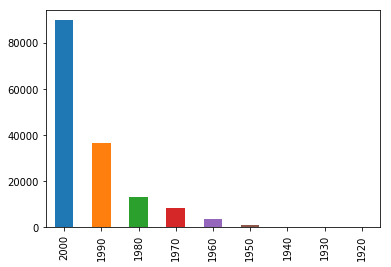

In [11]:
# plot count using bar plot
value_count_by_year = year_artist_name_title_genre['decade'].value_counts().plot(kind = 'bar')

print(year_artist_name_title_genre['decade'].value_counts())
value_count_by_year

We see that there are very few data points earlier than 1970, which makes analysis over time biased. During the next few steps as we explore the relationship between genre and decade further, we only consider the time period of 1970 to 2010. 

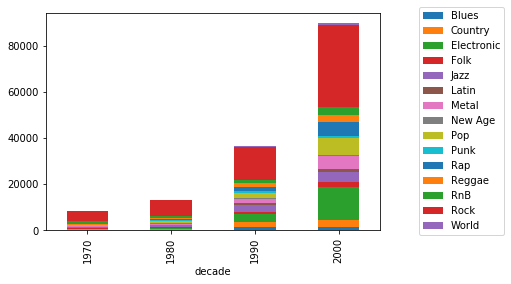

In [12]:
decade_genre = year_artist_name_title_genre[['decade', 'genre']].reset_index()

decade_genre = decade_genre.loc[decade_genre['decade'].isin(['1970','1980','1990','2000'])]

#print(decade_genre.groupby(['decade', 'genre']).size())
plot_decade_genre = decade_genre.groupby(['decade', 'genre']).size().unstack().plot(kind='bar', stacked = True)
plot_decade_genre.legend(bbox_to_anchor=(1.1, 1.05) )


We see that Rock music grew significantly in 40 years. Rock, Electronic, and Pop are the most popular music during the 2000s, followed by metal and Rap. The next plot considers the genres individually, and illustrates their share in the music market over the period of 1970 to 2010. 

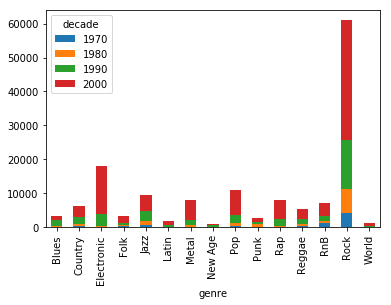

In [13]:
#print(decade_genre.groupby(['genre', 'decade']).size())
decade_genre.groupby(['genre', 'decade']).size().unstack().plot(kind='bar', stacked = True)

# TODO: improve this graph

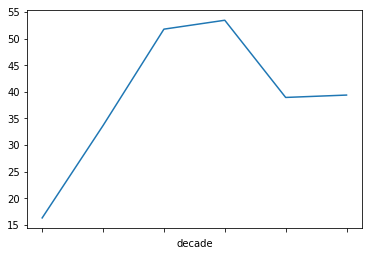

In [14]:
# Evolution of Rock

decade_rock = year_artist_name_title_genre.groupby(['genre','decade']).size()
(100*decade_rock['Rock']/(year_artist_name_title_genre.groupby('decade').size())).plot()


The plot is a bitt hard to read. The curve represents the percentage of rock tracks in our dataset through time. We can clearly see that it has increased drastically from the 60s to 2010. We believe that the slight decrease from 90s is due to the increasing success of RNB, rap, pop and Electronic music during that period.

In [15]:
100*decade_rock['Rock']/(year_artist_name_title_genre.groupby('decade').size())

decade
1920          NaN
1930          NaN
1940          NaN
1950    16.313559
1960    33.659218
1970    51.762590
1980    53.435346
1990    38.936582
2000    39.383940
dtype: float64

# 3. Getting the lyrics: Bag of words model from musicXmatch

The million songs dataset contains no lyrics. To conduct our study, we have the choice of either scraping the lyrics from the internet for each of the songs of the MSD or to use the ready-to-use bag of words model from musicXmatch.

We first wanted to scrape the lyrics from the internet, using the functions shown below in the notebook.
However, the MSD is too big and scraping the lyrics for our "year_artist_neame_title_genre" dataframe, which contains "only" 152793 tracks, would take us a few days. Moreover, we realized that the NLP would be difficult to handle for this project and decided to do simple statistics and models based on the bag of words provided by musicXmatch, that allowed for very easy processing of the data.

Therefore, the main lyrics dataset we use is the BOW from musicXmatch.
However, we will still use later the scrapping features, as explained later.

This section shows how we read and extract the words from the BOW.

In [21]:
# We read the text file line by line 

with open(os.path.join(data_dir + '/mxm_dataset_train.txt')) as f:
    lines = f.readlines()

In [22]:
# The 5'000 most used words sorted by overall occurences are in the 18th line. 
# We split the words by ',' to have a list of words

words = lines[17][1:]
words = words.split(',')

Now, for the rest of the file, we have, for each line, a track id and a list of tuplets. A tuplet ( key:value) consists of:
 - a key ( a number ) which represents the identifier of the word ( 1 means the 1st word in our words list etc ).
 - a value which is the occurences of the word in the track.
 
In the following cells, we extract this information and we change the numbered keys to "word keys"

In [23]:
# First, we split to have a list of tracks

bow = lines[18:]
for i in range(0,len(bow)):
    bow[i] = bow[i].split(',')

For each track in bow and for each tuplet in the track, extract the key ( the numbers before ':') then replace it by the corresponding word

In [24]:
for i in range(0,len(bow)):
    for j in range(2,len(bow[i])):
        '''
        For each track in bow and for each tuplet in the track, extract the key ( the numbers before ':')
        then replace it by the corresponding word
        '''
        key = bow[i][j][ 0 : bow[i][j].find(':') ]
        bow[i][j] = bow[i][j].replace(key,words[int(key)-1])
        
    # The last tuplet in each track has a line skip special character.
    # The next code will take the last tuplet with the special character
    bow[i][len(bow[i])-1] = bow[i][len(bow[i])-1][0:len(bow[i][len(bow[i])-1])-1]

In [25]:
# Extract the track id 

track_id = []
for i in range(0, len(bow)):
    track_id.append(bow[i][0])

Now that we have been able to extract and format the BOW information in an useful way, we can start building a model to associate each song with a degree of "positiveness" or "sexism" with respect to the image of women.

# 4. Building a simple model for feminism

## TODO: COMPLETE THE EXPLANATION

We want to build a simple model for feminism. Our method is the following:

1. First we find user defined playlists of **feminist** - or at least positive with respect to women -, **sexist** and **neutral** - with no mention of women or without any positive or negative image of women in the lyrics - songs from the internet.

2. Then, we manually (and painfully) list these songs in this notebook (in the "XXX_to_scrape" lists) and use some custom combination of scraping code to scrape the lyrics associated with these songs. _Note that the songs from the user-defined playlist were not all in the BOW dataset. We wanted to get as many user-defined songs as possible that would no be in the BOW model, to later train our model and apply it to the BOW set._

3. Afterwards, we save the BOW lyrics of the positive, sexist and neutral songs into dataframes. Then, we manually take a look at the BOWs and we identify ourselves what postive or sexist "keywords" are appearing often in the corresponding BOWs. We make sure the identified keywords are relevant for discriminating sexists songs from positive ones, by removing the keywords that appear too often or too sparsely. The result of this operation is a list of positive keywords and a list of sexist keywords, that are manually input into this notebook.

4. Then, we create a feature list from the lists of keywords by adding the positive and sexist keywords lists. For each feature (positive or negative keyword), we count the number of occurences in the user-labeled (positive, sexist or neutral) songs BOWs. This allows us to build a training set on this model, where each song from the training set is labeled as either positive, sexist or neutral with respect to the image of women it depicts, and has a count of the number of occurences of specific keywords.

5. Using your training set, we train a SVM, XXXXX model that can identify feminist, neutral and sexists songs based on their BOWs.

6. Then, we try to train again SVM, XXX and XXX not based on the counts of occurences of keywords but rather on the whole lyrics sentences themselves.

7. After discussing each method, we will be able to label the whole MSD with our trained classifier, identifying feminist, neutral of sexist songs.



## 4.1. Coding some efficient scraping tool

The function "scrape_lyrics" is the main function that allow us to scrape the lyrics from several lyrics websites.

In [9]:
def scrape_lyrics(artists_list,songs_list):
    '''
    Main scrapping function
    Input: lists of songs and their artists names 
    Output: list of lyrics of the songs and list of songs for which the scrapping did not succeed
    In case the scrapping failed, lyrics are returned as empty strings
    
    The lyrics are scrapped from several websites:
    - metrolyrics
    If failed:
    -azlyrics
    If failed also:
    - lyricswikia
    And if it also failed:
    - through the herokuapp online API (unknown source)
    
    '''
    
    lyrics_not_found = []
    if (len(artists_list) == 0 or len(songs_list) == 0):
        raise ValueError('The provided artists list or songs list is empty')
        
    elif (len(artists_list) != len(songs_list)):
        print("artist list has len: ", len(artists_list))
        print("songs list has len: ", len(songs_list))
        raise ValueError('The provided artists and songs lists have different lenghts')
        
    else:
        lyrics = []
        
        for i in tqdm(range(len(artists_list))):
            
            try:
                lyrics_metro = str(lyricfetcher.get_lyrics('metrolyrics',artists_list[i],songs_list[i]))
                lyrics_metro = re.sub(r'[\[].*?[\]]', '', lyrics_metro.replace('\n', ' '))
                lyrics_metro = re.sub(',', '', lyrics_metro)

                if (lyrics_metro == "" or len(lyrics_metro.split())<3):
                    lyrics_az = str(lyricfetcher.get_lyrics('azlyrics',artists_list[i],songs_list[i]))
                    lyrics_az = re.sub(r'[\[].*?[\]]', '', lyrics_az.replace('\n', ' '))
                    lyrics_az = re.sub(',', '', lyrics_az)

                    if (lyrics_az == "" or len(lyrics_az.split())<3):
                        lyrics_wikia = str(lyricfetcher.get_lyrics('lyricswikia',artists_list[i],songs_list[i]))
                        lyrics_wikia = re.sub(r'[\[].*?[\]]', '', lyrics_wikia.replace('\n', ' '))
                        lyrics_wikia = re.sub(',', '', lyrics_wikia)
                        
                        if (lyrics_wikia == "" or len(lyrics_wikia.split())<3):
                            try:
                                lyrics_herokuapp = json.load(urllib.request.urlopen('http://lyric-api.herokuapp.com/api/find/' 
                                                                                + artists_list[i].replace(' ', '%20') + '/' 
                                                                                + songs_list[i].replace(' ', '%20') + '.html'))['lyric']
                            except HTTPError:
                                lyrics_herokuapp = ''
                                
                            lyrics_herokuapp = re.sub(r'[\[].*?[\]]', '', lyrics_herokuapp.replace('\n', ' '))
                            lyrics_herokuapp = re.sub(',', '', lyrics_herokuapp)
                            
                            if (lyrics_herokuapp == "" or len(lyrics_herokuapp.split())<3):
                                raise ValueError('No lyrics OR lyrics smaller or equal to 2 words found')
                                
                            else:
                                lyrics.append(lyrics_herokuapp)
                        else:
                            lyrics.append(lyrics_wikia)
                    else:
                        lyrics.append(lyrics_az)
                else:
                    lyrics.append(lyrics_metro)
                
            except:
                lyrics_not_found.append([artists_list[i],songs_list[i]])
                lyrics.append("")
                continue
                
    return lyrics, lyrics_not_found

## 4.2. Structure the data from the scrapping

Now, we code the "create_BOW_dataframe" to create in practice the BOW dataframe from the artists and titles lists. It calls the "scrape_lyrics" functions, tokenize and stems the words in order to create the BOW.

In [28]:
def create_BOW_lyrics_dataframe(artists_to_scrape, titles_to_scrape, dataframe_csv_file_name):

    if any("," in s for s in titles_to_scrape):
        s.replace(",", "")
    
    if any("," in s for s in artists_to_scrape):
        s.replace(",", "")
    
    # The line below calls the scrapping function
    lyrics, lyrics_not_found_list = scrape_lyrics(artists_to_scrape, titles_to_scrape)

    # Prints relevant information
    print(lyrics_not_found_list)
    print('Count of not found lyrics : ' + str(len(lyrics_not_found_list)))
    
    # Tokenize and stem the lyrics
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    
    tokenized_lyrics = []
    
    for lyrics in lyrics:
        tokens = nltk.word_tokenize(lyrics)
        stemmed_tokens = [ps.stem(token) for token in tokens] 
        tokenized_lyrics.append(stemmed_tokens)

    lyrics_df = pd.DataFrame({'Artists': artists_to_scrape,
                                    'Titles': titles_to_scrape,
                                    'Lyrics(BOW)': tokenized_lyrics
                                   })

    # Save the stemmed version of the lyrics with title and artist to csv

    lyrics_df.to_csv(os.path.join(data_dir + dataframe_csv_file_name)) # Comment/uncomment when saving is needed
    
    return tokenized_lyrics, lyrics_df

In [35]:
# Define here the name of the dataframe csv in the data folder

sexist_csv = "/sexist_lyrics_dataframe.csv"
positive_csv = "/positive_lyrics_dataframe.csv"
neutral_csv = "/neutral_lyrics_dataframe.csv"

## 4.3. Create the positive, neutral and sexist lyrics dataframes

### 4.3.1 From user defined positive (feminist) songs

In [1]:
#Provide BELOW the full set of tracks you would like to get in final (XXX_to_scrape)
#-----------------------------------------------------------------------------
positive_titles_to_scrape = ['About a Girl', "Ain't No Way to Treat a Lady", "Ain't Nothin' Goin' On but the Rent", "Ain't Your Mama", 'All Hands on Deck', 'All I Wanna Do', 'All Woman', 'Anything You Can Do (I Can Do Better)', 'Asking for It', 'Bag It Up', 'Be a Man', 'Beautiful', 'Beautiful Liar', 'Bickenhead', 'Bills Bills Bills', 'Bitch', 'Bitch Bad', 'Black Magic', 'Black Widow', 'Born This Way', 'Boss', 'Bossy', 'Boys Wanna Be Her', 'Break Free', "Brenda's Got a Baby", 'Broken Heels', 'Bulletproof', 'Call Me', "Can't Hold Us Down", 'Catch My Breath', 'Chick Fit', 'Cinderella', 'Commander', 'Conceited', 'Confident', 'Control', 'Cornflake Girl', 'Creep', 'Dancing Barefoot', 'Dear Mama', 'Dicknail', 'Diva', 'Django Jane', 'Do It like a Dude', 'Do Right Woman Do Right Man', 'Doubt', 'Drunk Girl', 'Dust Cake Boy', 'Electric Lady', 'Express Yourself', 'Fall in Line', 'Fancy', 'Feedback', 'Female', 'Fight Like a Girl', 'Fighter', 'Flawless', 'FM Doll', 'Follow Your Arrow', 'Four Women', 'G.U.Y.', 'Get Some', 'Girl', 'Girl in a Country Song', 'Girl on Fire', 'Girls Just Want to Have Fun', 'Girls with Guitars', 'God Is a Woman', 'Good Good', 'Hair', 'Handle Me', 'Hard out Here', "He Thinks He'll Keep Her", 'Hey Hey Hey', 'Hey Mama', "Hit 'Em Up Style (Oops!)", 'Hollaback Girl', 'Human Nature', 'Hush Hush; Hush Hush', 'I Am Woman', 'I Do Not Hook Up', "I Don't Think About You", 'I Got That', 'I Hate Boys', 'I Love It', 'I Will Survive', "I'm Coming Out", "I'm Every Woman", 'If I Were a Boy', 'Independence Day', 'Independent Women', 'Irreplaceable', "It's Not Right but It's Okay", 'Joan of Arc', 'Jump', 'Just a Girl', 'Keep Ya Head Up', "Keeps Gettin' Better", 'Kick Your Game', 'Kool Thing', 'Lady Powers', 'Ladykillers', 'Learn to Let Go', 'Leash Called Love', 'Let It Go', 'Liberty Walk', 'Like a Boy', 'Lipstick', 'Listen', 'Little Baby Nothing', 'Little Me', 'Live It Up', 'Lookin Ass', "Love 'Em All", 'Love Myself', 'Lush Life', 'Man! I Feel Like a Woman!', 'The March of the Women', 'Me & My Girls', 'Me Myself and I', 'Miss Independent', 'Most Girls', 'Nasty', 'New Rules (song)', 'Nice for What', 'No', 'No Black Person Is Ugly', 'No More Tears (Enough Is Enough)', 'No Scrubs', 'No You Girls', 'None of Your Business', 'Nothing to Prove', 'Obsessed', 'Oh Bondage Up Yours!', 'Oops (Oh My)', "Papa Don't Preach", 'Paper or Plastic', 'Part of Me', 'Part of Your World', 'Partition', "People Grinnin'", 'Picture to Burn', 'The Pill', 'Polly', 'Power', "Pretend We're Dead", 'Pretty Girl', 'Pretty Girl Rock', 'Pretty Girls', 'Pretty Hurts', 'Primadonna', 'Pynk', 'Q.U.E.E.N.', 'Real Things', "Really Don't Care", 'Rebel Girl', 'Red Dress', 'Respect', 'Roar', 'Rock Steady', 'A Rose Is Still a Rose', 'Run the World (Girls)', 'Salute', "Say You'll Be There", 'Scars to Your Beautiful', 'Second Skin', 'Secrets', 'She', 'She Bop', 'She Loves Control', 'She Works Hard for the Money', 'Sheena Is a Punk Rocker', 'Sheezus', 'Single Ladies (Put a Ring on It)', 'Sisters O Sisters', 'Sit Still Look Pretty', 'Skinny Genes', 'Skyscraper', 'Sledgehammer', 'SMS (Bangerz)', 'So What', 'Sorry', 'Strong Enough', 'Stronger', "Stronger (What Doesn't Kill You)", 'Stupid Girls', 'Superwoman', 'Superwoman', 'Survivor', 'Sweet but Psycho', 'U + Ur Hand', 'U.N.I.T.Y.', 'Ugly', 'Ugly Heart', 'Unpretty', 'Unstoppable', 'Unwritten', 'Upgrade U', 'Violet', 'Wannabe', 'Warrior', 'What It Feels Like for a Girl', 'What You Waiting For?', 'Whatcha Think About That', 'When a Man Loves a Woman', 'When I Grow Up', 'White Houses', 'Who Let the Dogs Out?', 'Who Says', "Who's That Girl", 'Whole Lotta Woman', 'Wild Things', 'Wind It Up', 'Woman', 'Woman Is the Nigger of the World', "Woman's World", 'Womanizer', "A Woman's Worth", 'Women', 'Worth It', 'Yang Yang', "You Don't Know Me", "You Don't Own Me", 'You Oughta Know']
positive_artists_to_scrape =['Sugababes', 'Helen Reddy', 'Gwen Guthrie', 'Jennifer Lopez', 'Tinashe', 'Sheryl Crow', 'Lisa Stansfield', 'Ethel Merman', 'Hole', 'Geri Halliwell', 'Hole', 'Christina Aguilera', 'Shakira', 'Cardi B', "Destiny's Child", 'Meredith Brooks', 'Lupe Fiasco', 'Little Mix', 'Iggy Azalea', 'Lady Gaga', 'Fifth Harmony', 'Kelis', 'Peaches', 'Ariana Grande', 'Tupac Shakur', 'Alexandra Burke', 'La Roux', 'Blondie', 'Christina Aguilera', 'Kelly Clarkson', 'All Saints', 'i5', 'Kelly Rowland', 'Remy Ma', 'Demi Lovato', 'Janet Jackson', 'Tori Amos', 'TLC', 'Patti Smith', '2Pac', 'Hole', 'Beyonce', 'Janelle Monae', 'Jessie J', 'Aretha Franklin', 'Mary J. Blige', 'Chris Janson', 'Babes in Toyland', 'Janelle Monae', 'Madonna', 'Christina Aguilera', 'Drake', 'Janet Jackson', 'Shane McAnally', 'Bomshel', 'Christina Aguilera', 'Beyonce', 'Queenadreena', 'Kacey Musgraves', 'Nina Simone', 'Lady Gaga', 'Lykke Li', "Destiny's Child", 'Maddie & Tae', 'Alicia Keys', 'Cyndi Lauper', 'Mary Chapin Carpenter', 'Ariana Grande', 'Ashanti', 'Little Mix', 'Robyn', 'Lily Allen', 'Mary Chapin Carpenter', 'Katy Perry', 'David Guetta', 'Blu Cantrell', 'Gwen Stefani', 'Madonna', 'Pussycat Dolls', 'Jordin Sparks', 'Kelly Clarkson', 'Kelly Clarkson', 'Amil', 'Christina Aguilera', 'Icona Pop', 'Gloria Gaynor', 'Diana Ross', 'Chaka Khan', 'Beyonce', 'Martina McBride', "Destiny's Child", 'Beyonce', 'Whitney Houston', 'Little Mix', 'Madonna', 'No Doubt', '2Pac', 'Christina Aguilera', 'TLC', 'Sonic Youth', 'Vera Blue', 'Lush', 'Kesha', 'Sugarcubes', 'Idina Menzel', 'Miley Cyrus', 'Ciara', 'Alesha Dixon', 'Beyonce', 'Manic Street Preachers', 'Little Mix', 'Jennifer Lopez', 'Nicki Minaj', 'K.Michelle', 'Hailee Steinfeld', 'Zara Larsson', 'Shania Twain', 'Cicely Hamilton', 'Selena Gomez', 'Beyonce', 'Kelly Clarkson', 'Hailee Steinfeld', 'Janet Jackson', 'Dua Lipa', 'Drake', 'Meghan Trainor', 'Lil B', 'Barbra Streisand', 'TLC', 'Franz Ferdinand', 'Salt-n-Pepa', 'Doubleclicks', 'Mariah Carey', 'X-Ray Spex', 'Tweet', 'Madonna', 'Brooke Candy', 'Katy Perry', 'Jodi Benson', 'Beyonce', 'Nervo', 'Taylor Swift', 'Loretta Lynn', 'Nirvana', 'Little Mix', 'L7', 'Maggie Lindemann', 'Keri Hilson', 'Britney Spears', 'Beyonce', 'Marina and the Diamonds', 'Janelle Monae', 'Janelle Monae', 'Javine', 'Demi Lovato', 'Bikini Kill', 'Sugababes', 'Aretha Franklin', 'Katy Perry', 'All Saints', 'Lauryn Hill', 'Beyonce', 'Little Mix', 'Spice Girls', 'Alessia Cara', 'The Gits', 'Mary Lambert', 'Green Day', 'Cyndi Lauper', 'Camila Cabello', 'Donna Summer', 'the Ramones', 'Lily Allen', 'Beyonce', 'Yoko Ono', 'Daya', 'Eliza Doolittle', 'Demi Lovato', 'Fifth Harmony', 'Miley Cyrus', 'P!nk', 'Madonna', 'Cher', 'Britney Spears', 'Kelly Clarkson', 'P!nk', 'Alicia Keys', 'Karyn White', "Destiny's Child", 'Ava Max', 'P!nk', 'Queen Latifah', 'Fantasia', 'G.R.L', 'TLC', 'Sia', 'Natasha Bedingfield', 'Beyonce', 'Hole', 'Spice Girls', 'Nina Sublatti', 'Madonna', 'Gwen Stefani', 'The Pussycat Dolls', 'Jody Watley', 'The Pussycat Dolls', 'Vanessa Carlton', 'Baha Men', 'Selena Gomez', 'Robyn', 'Kelly Clarkson', 'Alessia Cara', 'Gwen Stefani', 'Kesha', 'John Lennon', 'Cher', 'Britney Spears', 'Alicia Keys', 'Amanda Lear', 'Fifth Harmony', 'Yoko Ono', 'Jax Jones', 'Lesley Gore', 'Alanis Morissette']
#-----------------------------------------------------------------------------

In [31]:
positive_tokens, positive_lyrics = create_BOW_lyrics_dataframe(positive_artists_to_scrape, positive_titles_to_scrape, positive_csv)

100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:54<00:00,  4.11it/s]


[['Shane McAnally', 'Female'], ['Mary Chapin Carpenter', 'Girls with Guitars'], ['K.Michelle', "Love 'Em All"], ['Cicely Hamilton', 'The March of the Women'], ['Beyonce', 'Me Myself and I'], ['Doubleclicks', 'Nothing to Prove'], ['Lauryn Hill', 'A Rose Is Still a Rose'], ['G.R.L', 'Ugly Heart'], ['Amanda Lear', 'Women']]
Count of not found lyrics : 9


### 4.3.2. From the user defined sexist songs

In [32]:
sexist_artists_to_scrape=["Foreigner","CyndiLauper","RayJ","AdinaHoward","Cassie","Tone-Loc","GeorgeMichael","DonnaSummer","Prince","JohnnyGill","Juvenile","RobertaFlack","Sylvia","DefLeppard","R.Kelly","Poison","MarvinGaye","DonnaSummer","Labelle","PeterGabriel","MissyElliott","ThePointerSisters","Heart","Usher","KarynWhite","Akon","R.Kelly","BellBivDevoe","Silk","GregoryAbbott","StarlandVocalBand","50Cent","Monica","AnitaWard","NellyFurtado","ToniBraxton","ColorMeBadd","DonnaSummer","LilWayne","TheRollingStones","RodStewart","Exile","Madonna","Captain&Tennille","DonnaSummer","MarvinGaye","Next","BoyzIIMen","RodStewart","OliviaNewton-John","LilWayne","TheDeadExs","MajorLazer","YoungMoney","EnriqueIglesias","RobinThicke","Kiss","BritneySpears","LilWayne","Dr.Dre","DavidGuetta","NickiMinaj","Whitesnake","AnalCunt","ChrisBrown","Prince","Falco","TheMentors","TheProdigy","Eminem","Eminem","DierksBentley","Nickelback","YoungMoney","VanHalen","RobertHazard","DemiLovato","BonJovi","AlannahMyles","Prince","Manika","ChristinaAguilera","Rihanna","Maroon5","FettyWap","Akon","Raelynn","SirMixALot","NotoriousBIG","TylerFarr","Usher","Syd","TheCitrusCloud","RoJames","SiR","Miguel","CharliePuth","Miguel","Nao","HarryStyles","LanaDelRey","LanaDelRey","Shaggy","TheCrystals","OneDirection","Beatles","TheWeeknd","AlexGaudino","BobSinclar","Vleger","SashaLopez","DavidGuetta","Pitbull","EricPrydz","Madonna","FeddeLeGrand","BlackEyedPeas","Eminem","FrankLoesser","JasonDerulo","YG","TylerTheCreator","Dr.Dre","Outkast","Eminem","WakaFlockaFlame","LilWayne","YingYangTwins","Common","GhostfaceKillah","Eminem","Eminem","Eminem","Eminem","SnoopDog","Eminem","Jeremih","ChrisBrown","Timbaland","Milow","ChrisBrown","Akon","Akon","Pitbull","Pitbull","Rocko","Rocko","AsapRocky","BennyBenassi"]
sexist_titles_to_scrape=["Urgent","Shebop","SexyCanI","FreakLikeMe","Me&U","WildThing","IWantYourSex","DimAllTheLights","RaspberryBeret","RubyoutheRightWay","SlowMotion","FeelLikeMakin'Love","PillowTalk","PourSomeSugaronMe","BumpN'Grind","UnskinnyBop","SexualHealing","LoveToLoveYouBaby","LadyMarmalade","Slegehammer","WorkIt","SlowHand","AllIWantToDoIsMakeLoveToYou","LoveInThisClub","Romantic","SmackThat","Ignition","DoMe!","FreakMe","ShakeYouDown","AfternoonDelight","CandyShop","TheFirstNight","RingMyBell","Promiscuous","You'reMakin'MeHigh","IWannaSexYouUp","BadGirls","Lollipop","HonkyTonkWomen","DaYaThinkI'mSexy","KissYouAllOver","LikeAVirgin","DoThatToMeOneMoreTime","HotStuff","Let'sGetItOn","TooClose","I'llMakeLoveToYou","Tonight'sTheNight","Physical","LoveMe","ShutUpandLoveMe","BubbleButt","Lookin'Ass","Tonight(I'mFuckin'You)","BlurredLines","IJustWanna","I'maSlave4U","HowtoLove","BitchesAin'tShit","HeyMama","Anaconda","SlowAn'Easy","Woman:Nature'sPunchingBag","Loyal","Cream","Jeanny","GoldenShower","SmackMyBitchUp","Superman","LovetheWayYouLie","DifferentforGirls","SomethinginYourMouth","EveryGirl","DropDeadLegs","GirlsJustWanttoHaveFun","BodySay","Let'sMakeItBaby","BlackVelvet","Kiss","IMightGoLesbian","Dirrty","S&M","Animals","679","IWannaFuckYou","GodMadeGirls","BabyGotBack","NastyGirl","RedneckCrazy","LoveInThisClub","SmileMore","LostWolves","BurnSlow","OohNahNah","PussyIsMine","Suffer","...goingtohell","BadBlood","FeelsLike","Love","LustForLife","ItWasn'tMe","HeHitMe","WhatMakesYouBeautiful","RunForYourLife","HighForThis","DestinationCalabria","WhatIWant","AfterNightInIbiza","BeautifulLife","PlayHard","InternationalLove","CallOnMe","HungUp","PutYourHandsUpForDetroit","MyHumps","KillYou","BabyIt'sColdOutside","Wiggle","TootitandBootit","Translyvania","BitchesAin'tShit","HootieHoo","ShakeThat","NoHands","AlphabetBitches","WaitTilYaSeeMyDick","HeidiHoe","Wildflower","AssLikeThat","GuiltyConscience","CleaningOutMyCloset","TheWarning","StepYoGameUp","WithoutMe","BirthdaySex","WetTheBed","CarryOut","AyoTechnology","Ayo","SexyBitch","IJustHadSex","HotelRoom","HeyBaby","YouDon'tEvenKnowIt","U.O.E.N.O.","Fuckin'Problems","Satisfaction"]

In [33]:
sexist_tokens, sexist_lyrics = create_BOW_lyrics_dataframe(sexist_artists_to_scrape, sexist_titles_to_scrape, sexist_csv)

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  4.39it/s]


[['Peter Gabriel', 'Slegehammer'], ['The Dead Exs', 'Shut Up and Love Me'], ['The Citrus Cloud', 'Lost Wolves'], ['SiR', 'Ooh Nah Nah'], ['Harry Styles', 'Feels Like'], ['Vleger', 'After Night In Ibiza'], ['Tyler The Creator', 'Translyvania']]
Count of not found lyrics : 7


### 4.3.3. From the user-defined "neutral" songs

In [ ]:
neutral_titles_to_scrape =  ["these arms of mine", "she", "green garden", "hotline bling", "three little birds", "masterblaster", "inner city blues", "move on up", "use me", "papa was a rolling stone", "richman poorman", "Is It Because I'm Black", "feeling good", "weird fishes", "all i need", "no room for doubt", "close to you", "how deep is your love", "if i ain't got you", "better in tune with the infinite", "comfortably numb", "shine on your crazy diamond", "wish you were here", "stairway to heaven", "space oddity", "california dreamin'", "hotel california", "an other brick in the wall", "lose yourself to dance", "don't stop 'til you get enough", "mr. tambourine man", "blackbird", "breathe" , "time", "school", "sultans of swing", "dreams", "brothers in arms", "the sound of silence", "a horse with no name", "riders on the storm", "the look", "bohemian rhapsody","stuck in the middle with you", "superstition", "blame it on the boogie", "september", "celebration", "virtual insanity", "englishman in new york", "message in a bottle", "wonderwall", "creep", "no surprises", "zombie", "cold little heart","wasting my young years", "three little birds", "overcome", "redbone", "It Runs Through Me", "i need a dollar", "crazy", "this world", "i won't go for more", "Didn't Cha Know", "never gonna catch me", "them changes", "show you the way", "lovely day", "i wish", "sir duke", "living for the city", "don't let me down", "better together", "let it be", "river", "deathless", "let it happen", "kids", "parachute", "life on mars", "changes", "friendly fire", "deat meat", "no one knows", "lonely boy", "clint eastwood", "feel good inc.", "bittersweet symphony", "come together", "don't worry be happy", "stand by me", "happy", "get lucky", "let's grovve", "boogie wonderland", "i can't go for that (no can do)", "owner of a lonely heart", "the logical song", "lady d'arbanville", "unstoppable", "the lung", "jekyll", "breathing underwater", "walking on the moon", "change", "that's the spirit", "wild world", "father and son", "piano man", "hallelujah", "the curse", "taro", "breezeblocks", "in cold blood", "i like that", "tightrope", "come over", "fitzpleasure", "peace of mind", "reason", "video killed the radio star", "once in a lifetime", "the block", "afro blue", "i try", "you don't know my name", "disco yes", "i will survive", "the bare necessities", "what a wonderful world", "when the saints go marching in", "everybody need somebody", "hit the road jack", "in the summertime", "born to be wild", "all along the watchower", "piece of my heart", "son of a preacher man", "mercy", "lumberjack soul", "tum rakak", "my world", "shoes", "people make the workd go round", "gold", "chicken in the corn","skin teeth", "welcome to machine", "us and them", "brain damage", "have a cigar", "money", "learning to fly", "high hopes", "lost for words", "simple man", "free bird", "sweet home alabama", "smoke on tha water", "lazy", "child in time", "perfect strangers", "riverside", "just so", "blue lights", "jammin", "so much trouble in the world", "satisfy my soul", "crazy baldhead", "pimper's paradise", "what's going on", "have a talk with god", "don't you worry 'bout a thing", "ordinary pain", "knocks me off my feet", "summer soft", "too young to die", "strange fruit", "cry me a river", "I put a spell on you", "clocks", "paradise", "viva la vida", "titanium", "hello", "losing my religion", "in the air tonight", "proud mary", "time of the season", "a whiter shade of pale", "money for nothing", "walk of life", "brothers in arms", "private investigations", "telegraph road", "preacheman", "same to you", "your heart is as black as night", "who will comfort me"]
neutral_artists_to_scrape = ["otis redding", "laura mvula", "laura mvula", "drake", "bob marley", "stevie wonder",                "marvin gaye", "curtis mayfield", "bill withers", "the temptations",    "clinton fearon", "Tiken Jah Fakoly", "nina simone", "radiohead", "radiohead", "lianne la havas", "carpenters",                  "bee gees",              "alicia keys",        "ibeyi",                            "pink floyd",       "pink floyd",                  "pink floyd",         "led zeppelin",       "david bowie",  "the mamas and the papas", "eagles", "pink floyd",                       "daft punk",              "michael jackson",                "bob dylan", "the beatles", "pink floyd", "pink floyd", "supertramp", "dire straits", "fleetwood mac", "dire straits", "paul simon", "america", "the doors",                             "metronomy", "queen",           "stealers wheel",               "stevie wonder", "the jackson five", "earth wind & fire", "kool & the gang", "jamiroquai", "sting", "the police", "oasis", "radiohead", "radiohead",                             "the cranberries", "Michael Kiwanuka", "london grammar", "bob marley", "laura mvula", "childish gambino", "tom misch", "aloe blacc", "gnarls barkley", "selah sue", "selah sue",            "erykah badu", "flying lotus",             "thundercat", "thundercat", "bill withers", "stevie wonder", "stevie wonder", "stevie wonder", "the beatles", "jack johnson",          "the beatles", "ibeyi", "ibeyi", "tame impala", "mgmt", "sean lennon", "davie bowie", "davie bowie", "sean lennon", "sean lennon", "queens of the stone age", "the black keys", "gorillaz", "gorillaz", "the verve", "the beatles",          "bobby mcferrin",      "ben e king", "pharrell williams", "daft punk", "earth wind & fire", "earth wind & fire", "hall & oates", "yes",                        "supertramp", "cat stevens", "lianne la havas", "hiatus kaiyote", "hiatus kaiyote", "hiatus kaiyote", "the police", "sandra nkake", "lady bazaar", "cat stevens", "cat stevens", "billy joel", "jeff buckley", "agnes obel", "alt j", "alt j", "alt j",                    "janelle monae", "janelle monae", "the internet", "alt j", "selah sue", "selah sue", "the bugges", "talking heads",                       "akua naru", "erykah badu", "macy gray", "alicia keys", "tom misch", "gloria gaynor", "louis armstrong", "louis armstrong", "louis armstrong",                                  "blues brothers", "ray charles", "mungo jerry", "steppenwolf"                          , "the jimi hendrix experience", "janis joplin", "dusty springfield", "duffy", "miles bonny", "deluxe",            "deluxe", "deluxe", "michael jackson", "andreya triana", "brushy one string", "brushy one string", "pink floyd","pink floyd",         "pink floyd", "pink floyd", "pink floyd", "pink floyd", "pink floyd", "pink floyd",            "lynyrd skynyrd", "lynyrd skynyrd", "lynyrd skynyrd", "deep purple", "deep purple", "deep purple", "deep purple", "agnes obel", "agnes obel", "jorja smith", "bob marley", "bob marley", "bob marley",                  "bob marley", "bob marley", "marvin gaye", "stevie wonder", "stevie wonder",                                       "stevie wonder", "stevie wonder", "stevie wonder", "jamiroquai", "billie holiday", "Ella Fitzgerald", "nina simone", "coldplay", "coldplay", "coldplay",                      "david guetta", "erykah badu", "REM", "phil collins", "tina turner", "Zombies",                      "procol harum", "dire straits" ,               "dire straits", "dire straits", "dire straits", "dire straits",                 "melody gardot", "melody gardot", "melody gardot", "melody gardot"]

In [ ]:
neutral_tokens, neutral_lyrics = create_BOW_lyrics_dataframe(neutral_artists_to_scrape, neautral_titles_to_scrape, neutral_csv)

In [ ]:
positive_lyrics = pd.read_csv(os.path.join(data_dir + positive_csv))
neutral_lyrics = pd.read_csv(os.path.join(data_dir + neutral_csv))
sexist_lyrics = pd.read_csv(os.path.join(data_dir + sexist_csv))

## 4.4. Manually find keywords for modeling the image of women

### 4.4.1 Positive keywords

In [ ]:
positive_words = ["woman",'women','pretti','beauti','mama','ladi','better','live','life','worth',
                          'friend','strong','stronger','power','believ','learn','fire','star','best','fight',
                          'free','respect','human','queen','grow','dream','truth','liberti','boss','shine',
                          'sister','flawless','perfect','confid','independ','superwoman']

### 4.4.2 Negative keywords

In [ ]:
negative_words = ['bitch','bubbl','fuck','nigga','butt','feel','littl','hot','ass',
                   'bodi','shit','hoe','man','sex','shake','bad','hard','dick','touch',
                   'fuckin','pussi','lick','sexi','damn','money']

### 4.4.3 Create a feature list from the identified keywords

In [ ]:
feature_list = ['Title','BOW']
feature_list = feature_list + positive_words + negative_words

## 4.5 Count the occurences of each keyword in the scraped BOW

# TODO: add this section with final code

## 4.X Degrading terms : statistics and insights into the bag of words

In [ ]:
# From https://www.telegraph.co.uk/women/life/hag-harridan-crone-16-words-use-describe-older-women/

degrading_terms = ["battleaxe","bint","cougar","crone","frump",
                   "hag","harridan","hormonal","matronly","milf",
                   "mutton","bag","shrill","spinster","wench","witch"]

# From https://en.wikipedia.org/wiki/Category:Misogynistic_slurs

degrading_terms = degrading_terms + ["becky","bitch","boseulachi","cock","crone","cunt","doenjang",
                                     "poop","dyke","hag","harpy","slut","slut-shaming","squaw",
                                     "termagant","tranny","twat","virago","zhyd"]

# From https://en.wikipedia.org/wiki/Category:Slang_terms_for_women

degrading_terms = degrading_terms + ["yummy","trixie","butch","skintern","kitten","ratchet","moll"]

# From https://www.macmillandictionary.com/thesaurus-category/british/insulting-words-for-a-woman

degrading_terms = degrading_terms + ["witch","virago","frump","harridan","bird","candy","wench","girly"]

# Inspiration from https://sites.google.com/site/hiphopmusiclyrics/top-10-degrading-songs-towards-women

degrading_terms = degrading_terms + ["vagina","ass","shit","hole","dick","pussy"]

# From http://onlineslangdictionary.com/lists/most-vulgar-words/

degrading_terms = degrading_terms + ["cock-juggling","sucker","cumdump","assmucus","fucktoy","cuntee",
                                     "gangbang","fugly","fubugly","puppet","fuck-bitch"]

# From https://en.wiktionary.org/wiki/Appendix:English_sexual_slurs

degrading_terms = degrading_terms + ["ballbreaker","ballbuster","beef","clientapollas","changa","crow",
                                     "dog","dyke","fag","fish","minger","muffdiver","munter","pillow-biter",
                                     "skank","streetwalker","swallower","tabby","teaser","thais",
                                     "thespian","third-legger","thot","tickle-tail","whore"]

# From https://ht.ac.uk/category/?type=search&word=women#id=39814

degrading_terms = degrading_terms + ["carline","female","rib","biddy","judy","heifer","hay-bag","bint","tart",
                                     "babe","muff","lubra"]

# From https://www.huffingtonpost.ca/2013/09/10/offensive-words_n_3581599.html

degrading_terms = degrading_terms + ["buttaface","fashionista","mompreneut","wifey","sidebook","booty","feisty",
                                     "shrill","sweetie","honey-bun"]

# From https://www.telegraph.co.uk/women/life/ambitious-frigid-and-frumpy-25-words-we-only-use-to-describe-wom/

degrading_terms = degrading_terms + ["bombshell","bossy","bridezilla","bubbly","silly","ditsy","frigid","hormonal",
                                    "high-maintenance","hysterical","sassy","shrill","whinging"]

# From http://onlineslangdictionary.com/thesaurus/words%2Bmeaning%2Bwoman%2C%2Bwomen%2C%2Bfemale.html

degrading_terms = degrading_terms + ["candy","beast","beav","biddie","biddy","bimbo","bimho","bint","bisnotch",
                                     "breezie","breezy","bushpig","butterface","butterhead","chank","chica","chicadee","hoochie",
                                     "cow","crockadillapig","cronk","ditz","doll","dudette","fem-fetale","filly",
                                     "flange","flipper","floozie","floozy","foxy","gilf","heina","gyal","hoe","hogbeast","homegirl",
                                     "hooch","girl","hoochie","hoss","hunny","hussy","huzzie","savage","jumper","jumpoff","karena","lass",
                                     "lolita","lumberjack","ma'am","mami","manizer","manster","mif","millihelen","minger","mole","moll",
                                     "mudpout","poon","poontang","prostitot","pyt","queenpin","ragamuffin","rasp","rat","rub","sauerkraut","scud",
                                     "kitten","mama","shwaty","sheila","sista","skank","sorostitute","split-tail","toots","tramp","whooty","womyn","yak"]

# From https://www.thesaurus.com/browse/slut

degrading_terms = degrading_terms + ["harlot","prostitue","hooker","tart","floozy","vamp","escort","strumpet","hustler"]

degrading_terms = list(set(degrading_terms))

In [ ]:
negative_score = []

for i in range(0,len(bow)):
    neg_song=0
    for j in range(2,len(bow[i])):
        word = bow[i][j]
        key = word[ 0 : word.find(':') ]
        if(key in degrading_terms):
            occurence = word[word.find(':')+1:]
            neg_song += int(occurence)
    negative_score = negative_score + [bow[i][0],neg_song]
    

dist = []
for i in range(1,len(negative_score),2):
    dist.append(negative_score[i])

pd.Series(dist).plot(kind='hist', bins = 100)

for i in range(0,len(words)):
    if(words[i] in degrading_terms):
        print(words[i])